This notebook looks at the power to detect the "top hits" in the original dataset (as defined by their signal-to-noise ratio).

In [1]:
import pandas as pd
import numpy as np
import feather

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.style.use('seaborn-white')

The plan:
- define OTU ranks based on their signal to noise ratios [this is done in the population_effects.\*.txt files
- count the percent of "top hits" that get detected at each simulation setting
- calculate the "power" to detect half of the top hits for each simulation setting

In [2]:
fqvals = '../../data/analysis/power_simulation.otu_qvalues.30_reps.denovo_otu_only.feather'

qvals = feather.read_dataframe(fqvals)

In [15]:
qvals.head()

,taxa_level,p_allsamples,q_allsamples,p,test_stat,q,n_ctrl,n_case,total_n,perc_case,study,rep,denovo
0,otu,0.023282,0.052736,0.430990,0.620155,1.000000,9,1,10,0.10,cdi_schubert,0,d__denovo1106
1,otu,0.023282,0.052736,0.154776,2.024540,1.000000,8,3,10,0.25,cdi_schubert,0,d__denovo1106
2,otu,0.023282,0.052736,0.699854,0.148624,1.000000,5,5,10,0.50,cdi_schubert,0,d__denovo1106
3,otu,0.023282,0.052736,1.000000,0.000000,1.000000,3,8,10,0.75,cdi_schubert,0,d__denovo1106
4,otu,0.023282,0.052736,0.082006,3.024691,0.891149,1,9,10,0.90,cdi_schubert,0,d__denovo1106


In [59]:
alpha = 0.05
NTOPHITS = [3, 5, 10]

In [74]:
datasets = ['cdi_schubert', 'crc_baxter', 'ibd_papa', 'ob_goodrich']
POWER = []
NSIG = []

for d in datasets:
    # Read in file with the genus ranks, based on signal to noise
    feffects = '../../data/analysis/population_effects.{}.txt'.format(d)
    effects = pd.read_csv(feffects, sep='\t')

    sub_qvals = qvals.query('study == @d')

    for ntophits in NTOPHITS:
        # Define the top hits
        top_otus = effects.query('rank_snr < @ntophits')['denovo'].tolist()

        # Get the qvalues from each simulation setting
        top_qvals = sub_qvals.query('denovo == @top_otus')

        # Get rejected OTUs
        top_qvals.loc[top_qvals.index, 'rejected'] = top_qvals.loc[top_qvals.index, 'q'] <= alpha

        # Calculate number of top hits rejected in each simulation setting
        top_qvals = top_qvals.groupby(['total_n', 'perc_case', 'rep'])['rejected'].sum().reset_index()

        # How many and what percentage of those simulations were "powered" 
        powerthresh = np.ceil(0.5*ntophits)
        top_qvals['n_reps_powered'] = top_qvals['rejected'] > powerthresh
        power = top_qvals.groupby(['total_n', 'perc_case'])['n_reps_powered'].sum().reset_index()
        power['power'] = power['n_reps_powered'] / 30.0

        # Add study ID and append to list
        power['study'] = d
        power['n_top_hits'] = ntophits
        top_qvals['study'] = d
        top_qvals['n_top_hits'] = ntophits
        
        POWER.append(power)
        NSIG.append(top_qvals)

In [75]:
powerdf = pd.concat(POWER)
nsigdf = pd.concat(NSIG)

In [76]:
nsigdf.head()

,total_n,perc_case,rep,rejected,n_reps_powered,study,n_top_hits
0,10,0.1,0,0.0,False,cdi_schubert,3
1,10,0.1,1,0.0,False,cdi_schubert,3
2,10,0.1,2,0.0,False,cdi_schubert,3
3,10,0.1,3,0.0,False,cdi_schubert,3
4,10,0.1,4,0.0,False,cdi_schubert,3


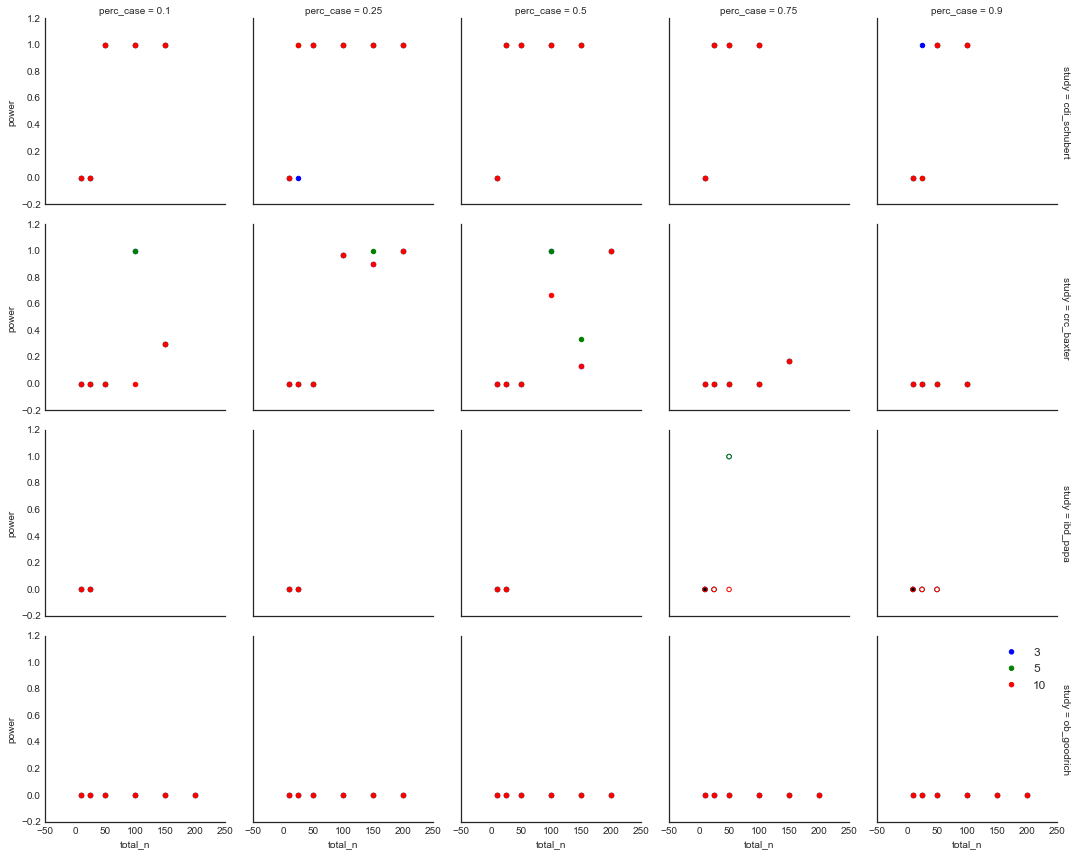

In [77]:
g = sns.FacetGrid(col='perc_case', row='study', 
                  data=powerdf, hue='n_top_hits',
                  sharey=True, margin_titles=True)
g.map(plt.scatter, 'total_n', 'power')
plt.legend(loc='upper right')

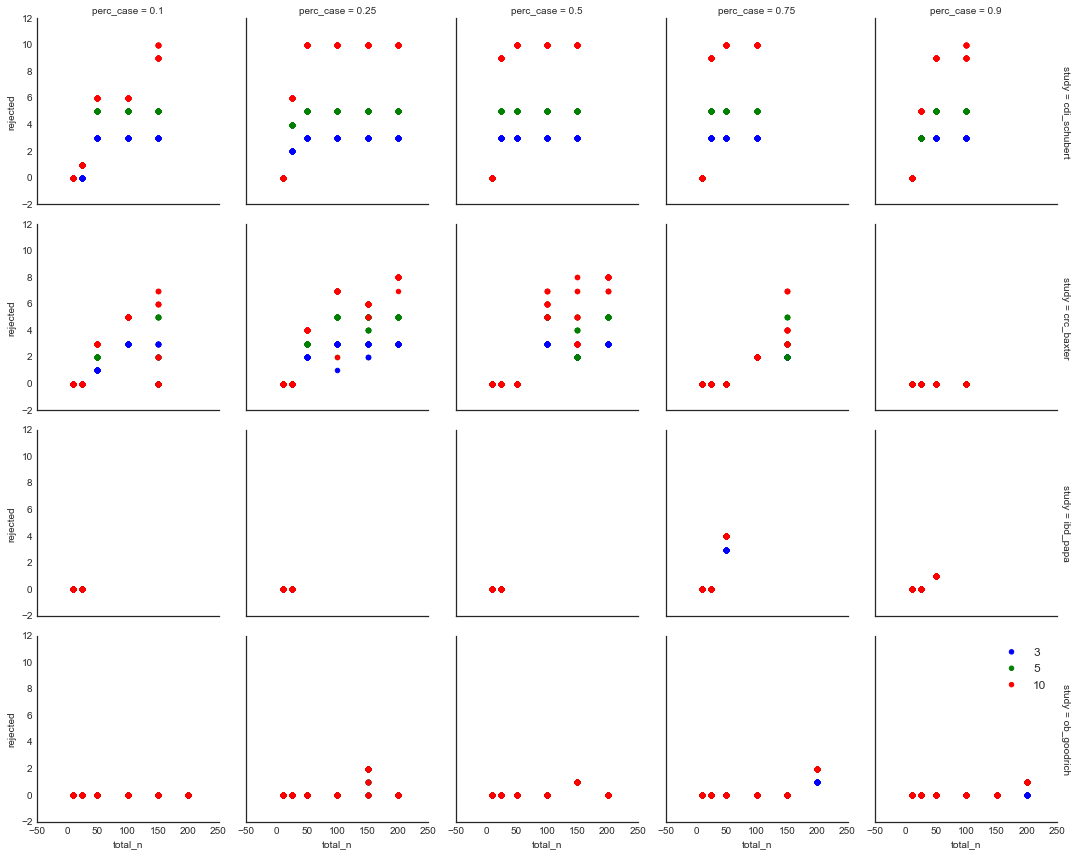

In [79]:
g = sns.FacetGrid(col='perc_case', row='study', 
                  data=nsigdf, hue='n_top_hits',
                  sharey=True, margin_titles=True)
g.map(plt.scatter, 'total_n', 'rejected')
plt.legend(loc='upper right')

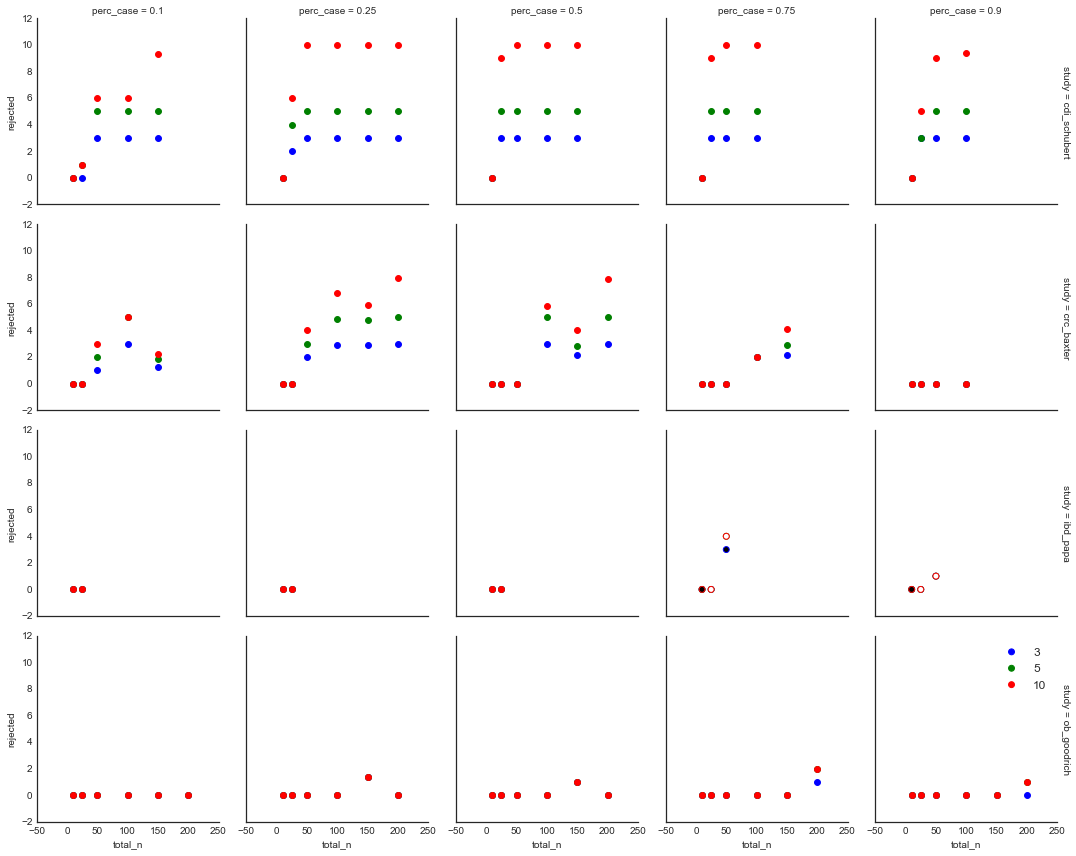

In [85]:
# Mean number rejected per simulation setting
meanreject = nsigdf.groupby(['total_n', 'perc_case', 'study', 'n_top_hits'])['rejected'].mean().reset_index()

g = sns.FacetGrid(col='perc_case', row='study', 
                  data=meanreject, hue='n_top_hits',
                  sharey=True, margin_titles=True)
g.map(plt.scatter, 'total_n', 'rejected', s=35)
plt.legend(loc='upper right')